# Looking for Proxy Metrics

## Import libraries

In [1]:
#!pip install scipy matplotlib statsmodels seaborn

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint

## Import data

In [3]:
df = pd.read_csv('proxy_metrics_homework_2.csv')

In [4]:
df

,user_id,views,contacts,last_7_views,last_3_views,last_7_contacts,last_3_contacts,live_days,messages_events,max_views_delta,add_to_favor_events,is_bought
0,151042503,84,2,84,39,2,2,8,0,6,0.0,0
1,151212422,95,0,95,36,0,0,8,0,7,0.0,0
2,151206815,118,3,118,40,3,2,8,0,2,0.0,0
3,151284254,11,0,11,2,0,0,7,0,8,0.0,0
4,151088604,48,2,48,8,2,0,8,0,1,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1195,142367169,2477,34,319,184,4,2,42,42,0,3.0,1
1196,149003341,469,15,231,168,8,8,41,9,1,0.0,1
1197,150878368,2663,23,2112,1213,23,17,10,24,0,0.0,1
1198,149351655,2673,39,1202,528,20,8,24,26,31,1.0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              1200 non-null   int64  
 1   views                1200 non-null   int64  
 2   contacts             1200 non-null   int64  
 3   last_7_views         1200 non-null   int64  
 4   last_3_views         1200 non-null   int64  
 5   last_7_contacts      1200 non-null   int64  
 6   last_3_contacts      1200 non-null   int64  
 7   live_days            1200 non-null   int64  
 8   messages_events      1200 non-null   int64  
 9   max_views_delta      1200 non-null   int64  
 10  add_to_favor_events  1200 non-null   float64
 11  is_bought            1200 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 112.6 KB


## Tasks

### Task 1.

 **Find an average conversion into buying a car.**

In [6]:
df.is_bought.mean()

0.3425

### Task 2.  

**What is the average number of contacts for the entire period for those who did not buy a car?**

In [7]:
df[df['is_bought'] == 0].contacts.mean()

13.135614702154626

### Task 3.

**Calculate how many times the average number of adds to favorites (add_to_favor_events) differs for each of the two cohorts (those who bought a car and those who did not buy a car).**

In [8]:
ans_3 = df.groupby('is_bought', as_index=False).agg({'add_to_favor_events': 'mean'})

ans_3

,is_bought,add_to_favor_events
0,0,0.158428
1,1,0.318735


In [9]:
ans_3.iloc[1].add_to_favor_events / ans_3.iloc[0].add_to_favor_events

2.01185401459854

### Task 4. 

**Find the percentage of users who have not made any contacts for each of the two cohorts (those who bought a car and those who did not buy a car).**

In [10]:
not_bought = df[df['is_bought'] == 0].shape[0]
not_bought_zero_contacts = df[(df['is_bought'] == 0) & (df['contacts'] == 0)].shape[0]

bought = df[df['is_bought'] == 1].shape[0]
bought_zero_contacts = df[(df['is_bought'] == 1) & (df['contacts'] == 0)].shape[0]

print(f'Zero contacts percentage among those who did not buy a car: {not_bought_zero_contacts / not_bought: .2%}')
print(f'Zero contacts percentage among those who bought a car: {bought_zero_contacts / bought: .2%}')

Zero contacts percentage among those who did not buy a car:  10.27%
Zero contacts percentage among those who bought a car:  3.65%


### Task 5. 

**Find the average LT (lifetime — duration from the first day to churn) for two cohorts.**

In [11]:
df.groupby('is_bought', as_index=False).agg({'live_days': 'mean'})

,is_bought,live_days
0,0,12.724968
1,1,10.150852


### Task 6. 

**Find the ratio between views and contacts for two cohorts.**

In [12]:
(df[df['is_bought'] == 0].contacts / df[df['is_bought'] == 0].views).mean()

0.022867884495711047

In [13]:
(df[df['is_bought'] == 1].contacts / df[df['is_bought'] == 1].views).mean()

0.034810729185530236

### Task 7. 

**Iterate through all metrics from the source data and find the TOP-3 metrics that have the best correlation with the fact of buying a car.**

Let's code a function that checks for correlation between a quantitative variable and a binary mask. 

In [14]:
def find_cat_quant_correlation(quant_value, binary_mask, plot=True, print_inference=True):
    '''
    quant_value - quantitative variable, for which we calculate the correlation
    binary_mask - binary variable (True, False), for which we calculate the correlation
    plot - whether to plot the graph
    print_inference - whether to print the conclusions and main metrics
    '''

    # Split the quantitative metric into groups based on whether the target conversion was made or not
    group_1 = quant_value[binary_mask]  # binary = 1
    group_2 = quant_value[~binary_mask]  # binary = 0

    # Calculate pointbiserial correlation, Kruskal-Wallis test and ordinary T-test
    pointbiserialr = ss.pointbiserialr(quant_value, binary_mask)[0]
    kruskal_pval = ss.kruskal(group_1, group_2)[1]
    ttest_pval = ss.ttest_ind(group_1, group_2)[1]

    # Print the conclusions
    if print_inference:
        print('Mean quant value for group (binary=1) =', group_1.mean())
        print('Mean quant value for group (binary=0) =', group_2.mean())

        print('Median quant value for group (binary=1) =', group_1.median())
        print('Median quant value for group (binary=0) =', group_2.median())

        print('Kruskal-Wallis H Test p-value =', kruskal_pval)
        print('T-test p-value =', ttest_pval)
        print('point biserial correlation =', pointbiserialr)

    # Plot the distribution graph for two groups to illustrate the differences in groups
    if plot:
        plt.figure(figsize=(16, 6))
        sns.kdeplot(group_1, color='red', label='Binary = True')
        sns.kdeplot(group_2, color='blue', label='Binary = False')
        plt.axvline(x=group_1.mean(), linestyle='--', color='red')
        plt.axvline(x=group_2.mean(), linestyle='--', color='blue')
        plt.legend()

    return {'point_biserial_r': pointbiserialr,
            'kruskal_pval': kruskal_pval,
            'ttest_pval': ttest_pval}

Let's check the function first on one feature. 

Mean quant value for group (binary=1) = 0.31873479318734793
Mean quant value for group (binary=0) = 0.15842839036755388
Median quant value for group (binary=1) = 0.0
Median quant value for group (binary=0) = 0.0
Kruskal-Wallis H Test p-value = 6.371276221602224e-18
T-test p-value = 0.030188195260747588
point biserial correlation = 0.06257746111140994


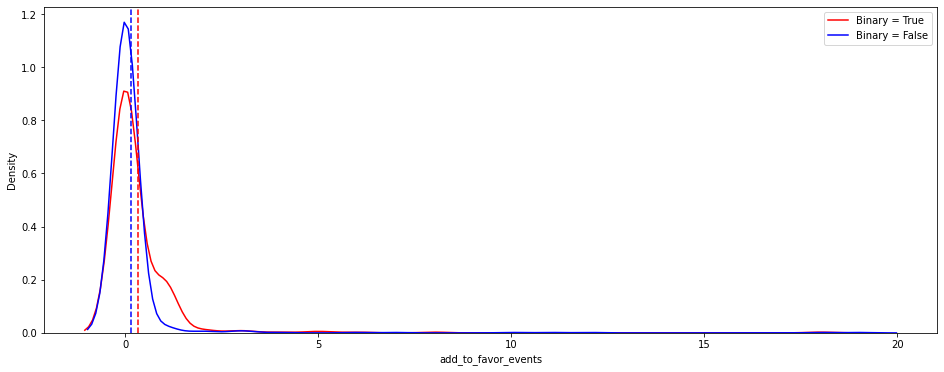

In [15]:
_ = find_cat_quant_correlation(df.add_to_favor_events, 
                               df['is_bought']==1,
                               plot=True,
                               print_inference=True)

And now we'll iterate through all features we have to find the top-3 most correlated ones.

In [16]:
cols = df.columns.to_list()
feature = []
corr = []

for col in cols[1:-1]:
    result = find_cat_quant_correlation(df[col],
                                        df['is_bought']==1,
                                        plot=False,
                                        print_inference=False)['point_biserial_r']
    
    feature.append(col)
    corr.append(result)
    
result_df = pd.DataFrame({
    'feature': feature,
    'correlation': corr
    })
    
result_df.sort_values('correlation', ascending=False).head(3)

,feature,correlation
5,last_3_contacts,0.359461
3,last_3_views,0.307544
4,last_7_contacts,0.280345


### Task 8. 

**Find the value of point biserial correlation between the metrics `is_bought` and `add_to_favor_events`.**

In [17]:
result_df[result_df['feature'] == 'add_to_favor_events'].correlation.values

array([0.06257746])

### Task 9. 

**Calculate the point biserial correlation coefficient for the logarithm of the metric `last_3_contacts`.**

Mean quant value for group (binary=1) = 1.89373516861593
Mean quant value for group (binary=0) = 0.9443381111904845
Median quant value for group (binary=1) = 1.9459101490553132
Median quant value for group (binary=0) = 0.6931471805599453
Kruskal-Wallis H Test p-value = 1.1733129557672549e-45
T-test p-value = 6.05383456974365e-52
point biserial correlation = 0.4180024619744416


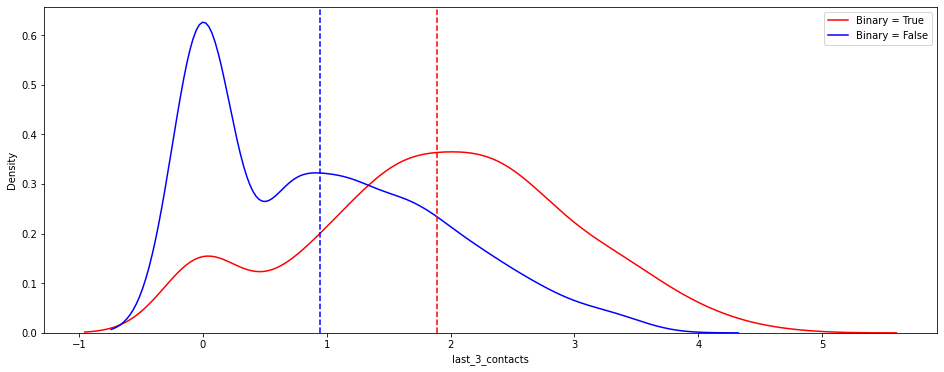

In [18]:
_ = find_cat_quant_correlation(np.log(df.last_3_contacts + 1), 
                               df['is_bought']==1,
                               plot=True,
                               print_inference=True)

We can see that logarithm transformation improved correlation between two metrics. 

### Task 10. 

**Calculate the point biserial correlation coefficient for the logarithm of the metric `last_3_views`.**

Mean quant value for group (binary=1) = 5.20715163753203
Mean quant value for group (binary=0) = 4.297350415932348
Median quant value for group (binary=1) = 5.267858159063328
Median quant value for group (binary=0) = 4.30406509320417
Kruskal-Wallis H Test p-value = 1.0890475540377117e-34
T-test p-value = 3.0049021456414015e-35
point biserial correlation = 0.34683549503186817


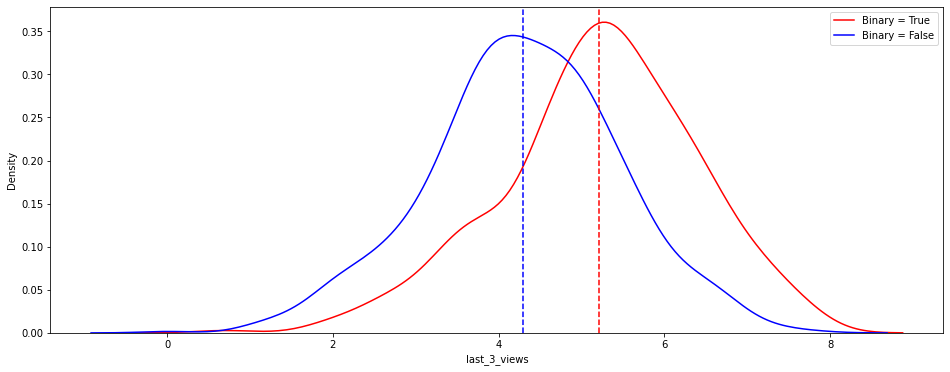

In [19]:
_ = find_cat_quant_correlation(np.log(df.last_3_views + 1), 
                               df['is_bought']==1,
                               plot=True,
                               print_inference=True)

We can see that logarithm transformation improved correlation for this feature as well.

### Task 11. 

**Calculate the point biserial correlation coefficient for the logarithm of the metric `add_to_favor_events`.**

Mean quant value for group (binary=1) = 0.16537194908164618
Mean quant value for group (binary=0) = 0.05164238378277397
Median quant value for group (binary=1) = 0.0
Median quant value for group (binary=0) = 0.0
Kruskal-Wallis H Test p-value = 6.371276221602224e-18
T-test p-value = 8.745672939133046e-09
point biserial correlation = 0.16511770268842738


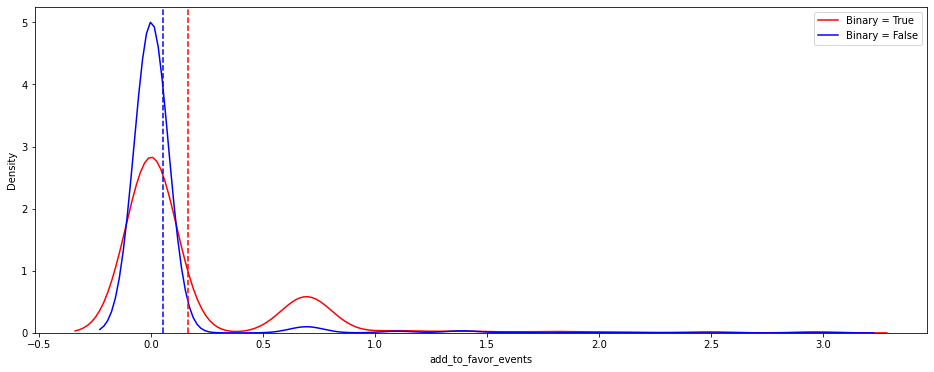

In [20]:
_ = find_cat_quant_correlation(np.log(df.add_to_favor_events + 1), 
                               df['is_bought']==1,
                               plot=True,
                               print_inference=True)

Logarithm transformation improved correlation for this feature as well.

### Task 12. 

**Calculate the point biserial correlation coefficient for the metric `last_3_contacts / (last_3_views +1)`.**

Mean quant value for group (binary=1) = 0.038695409686905165
Mean quant value for group (binary=0) = 0.027781371391765095
Median quant value for group (binary=1) = 0.028169014084507043
Median quant value for group (binary=0) = 0.012987012987012988
Kruskal-Wallis H Test p-value = 7.894887863928391e-19
T-test p-value = 3.030600767254425e-05
point biserial correlation = 0.12009995459500225


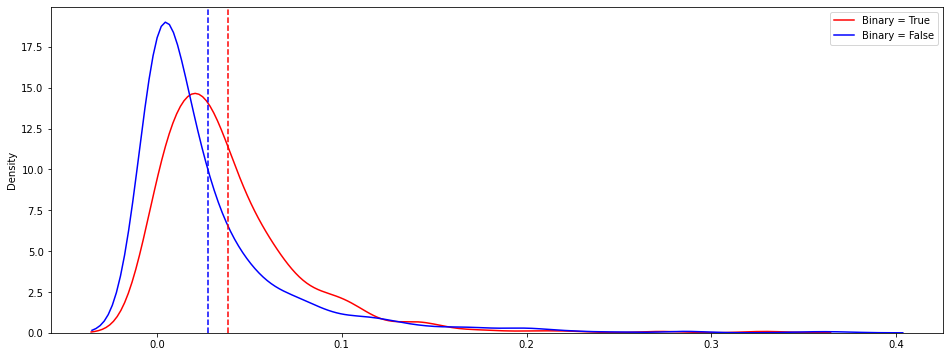

In [21]:
_ = find_cat_quant_correlation(df.last_3_contacts / (df.last_3_views + 1), 
                               df['is_bought']==1,
                               plot=True,
                               print_inference=True)

### Task 13. 

**Find the threshold for the proxy metric `last_3_contacts`.**

Calculating Cramers V statistic for categorial-categorial association.

In [22]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    cramers_v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    return (cramers_v)

Let's try to find a threshold at which the cramer V association coefficient will be maximal.

In [23]:
def max_cramerv_corr_finder(quant_value, binary_mask, plot=True, print_inference=True, step=1):
    """
    quant_value - the original quantitative variable for which we are trying to find a threshold
    binary_mask - the binary metric with the target conversion to which we are looking for the maximum correlation
    plot - whether to draw a graph
    print_inference - whether to print the results
    step - the size of the step with which we go through quant_value and define thresholds
    """

    # Define the vector of the original quantitative variable on which we will look for the maximum correlation
    arange = np.arange(min(quant_value), max(quant_value), step)
    cramers_v_list = []

    # Loop through all thresholds and find the cramers_v value
    for i in arange:
        confusion_matrix = pd.crosstab(binary_mask, quant_value > i)
        cramers_v_i = cramers_v(confusion_matrix.values)
        cramers_v_list.append(cramers_v_i)

    # Save the maximum values of the correlation found and the threshold at which it is achieved
    max_corr_quant_value = arange[np.argmax(np.array(cramers_v_list))]
    max_cramer_v = max(cramers_v_list)

    # Plot the graph
    if plot:
        sns.lineplot(x=arange, y=cramers_v_list)
        plt.axhline(y=np.array(cramers_v_list).max(), linestyle='--', color='red')
        plt.axvline(x=max_corr_quant_value, linestyle='--', color='red')
        plt.xlabel('quant values')
        plt.ylabel('Cramer-V')

    # Print the results
    if print_inference:
        print('Maximum Cramer V =', np.array(cramers_v_list).max())
        print('Maximum Cramer V quant value = ', max_corr_quant_value)

    return({'max_cramer_v': max_cramer_v,
            'max_corr_quant_value': max_corr_quant_value})

Maximum Cramer V = 0.3686253838357947
Maximum Cramer V quant value =  3


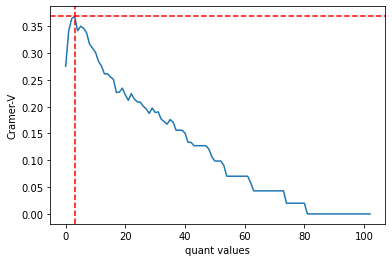

In [24]:
_ = max_cramerv_corr_finder(df.last_3_contacts, df['is_bought']==1,
                            plot = True, print_inference = True,
                            step = 1)

### Task 14.

**Find the threshold for the proxy metric `last_3_views`.**

Maximum Cramer V = 0.3438012439537349
Maximum Cramer V quant value =  151


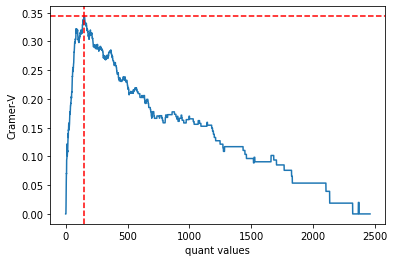

In [25]:
_ = max_cramerv_corr_finder(df.last_3_views, df['is_bought']==1,
                            plot = True, print_inference = True,
                            step = 1)

### Task 15. 

**Find the threshold for the proxy metric `add_to_favor_events`.**

Maximum Cramer V = 0.2497541756211998
Maximum Cramer V quant value =  0.0


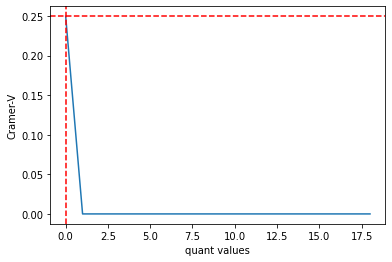

In [26]:
_ = max_cramerv_corr_finder(df.add_to_favor_events, df['is_bought']==1,
                            plot = True, print_inference = True,
                            step = 1)

### Task 16.

**Calculate the power of the z-test for the original target metric (the proportion of those who bought) and the proxy metric (`last_3_contacts`).**  

To estimate the power, use the following inputs:
- We will analyze the data that are in the file by conducting synthetic tests
- The number of simulations is 10,000
- The size of the added effect is +10% to conversion in the test group for both types of tests (for the main metric and for the proxy metric)

In [27]:
#AB test simulation
ab_binary_ztest_pvalue_list = []
ab_quant_ztest_pvalue_list = []
quant_target_level = 4  # define the treshold for the quantitative proxy metric
abs_effect = 0.1  # define the absolute effect size
n_sim = 10000  # define the number of simulations


for i in range(n_sim):
    # Generating a/b splitting mask
    sample_mask = ss.bernoulli.rvs(0.5, size=len(df)) == 1

    # Splitting data
    binary_mask_group_a = (df['is_bought']==1)[sample_mask]
    binary_mask_group_b = (df['is_bought']==1)[~sample_mask]
    quant_value_group_a = (df['last_3_contacts'])[sample_mask]
    quant_value_group_b = (df['last_3_contacts'])[~sample_mask]

    # Getting the number of samples in each group for the binary and quantative metrics
    binary_nobs_group_a = len(binary_mask_group_a)
    binary_nobs_group_b = len(binary_mask_group_b)
    quant_nobs_group_a = len(quant_value_group_a)
    quant_nobs_group_b = len(quant_value_group_b)
    
    # Calculate the conversion rates for the binary and quantitative metrics for each group
    binary_counts_group_a = binary_mask_group_a.sum()
    binary_counts_group_b = round(binary_mask_group_b.sum()*(1+abs_effect)) #add effect
    quant_counts_group_a = (quant_value_group_a >= quant_target_level).sum()
    quant_counts_group_b = round((quant_value_group_b >= quant_target_level).sum()*(1+abs_effect)) #add effect

    # Calculate the z-scores and p-values for the binary and quantitative metrics
    binary_z_score_i, binary_ztest_pvalue_i = sms.proportions_ztest(count = [binary_counts_group_a, binary_counts_group_b],
                          nobs = [binary_nobs_group_a, binary_nobs_group_b])
    quant_z_score_i, quant_ztest_pvalue_i = sms.proportions_ztest(count = [quant_counts_group_a, quant_counts_group_b],
                          nobs = [quant_nobs_group_a, quant_nobs_group_b])

    # Append the p-values to the lists
    ab_binary_ztest_pvalue_list.append(binary_ztest_pvalue_i)
    ab_quant_ztest_pvalue_list.append(quant_ztest_pvalue_i)

# Calculate the power 99% CI of the AB test for the binary and quantitative metrics
binary_power_ci = proportion_confint((np.array(ab_binary_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)
quant_power_ci = proportion_confint((np.array(ab_quant_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)


# Print the results
print('Effect =', abs_effect)
print('Sample size A group =', binary_nobs_group_a)
print('Sample size B group =', binary_nobs_group_b, end='\n\n')

print('Target conversion A group =', binary_counts_group_a / binary_nobs_group_a)
print('Target conversion B group =', binary_counts_group_b / binary_nobs_group_b)
print('Proxy conversion A group =', quant_counts_group_a / quant_nobs_group_a)
print('Proxy conversion B group =', quant_counts_group_b / quant_nobs_group_b, end='\n\n')

print('Target conversion AB testing power:', (np.array(ab_binary_ztest_pvalue_list) <= 0.05).sum() / n_sim)
print('Target conversion AB testing power 99% CI:', binary_power_ci)
print('Proxy conversion AB testing power:', (np.array(ab_quant_ztest_pvalue_list) <= 0.05).sum() / n_sim)
print('Target conversion AB testing power 99% CI:', quant_power_ci)

Effect = 0.1
Sample size A group = 599
Sample size B group = 601

Target conversion A group = 0.34056761268781305
Target conversion B group = 0.3793677204658902
Proxy conversion A group = 0.4307178631051753
Proxy conversion B group = 0.4509151414309484

Target conversion AB testing power: 0.2497
Target conversion AB testing power 99% CI: (0.23855079697439935, 0.26084920302560066)
Proxy conversion AB testing power: 0.3187
Target conversion AB testing power 99% CI: (0.30669734547778, 0.33070265452222)
